In [1]:
# %% 
# Environment & Imports
import sys
import os

# Point to the src folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

import networkx as nx
from trap import create_trap_graph
from verifier import verifier

/Users/nd/OS/Code/quantum-hackaton-2025/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# %% [markdown]
# ## 1. Load & inspect the trap graph

# %% 
G = create_trap_graph()
print(f"Total nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

# Inspect a few node attributes
sample = list(G.nodes)[:5]
print("Sample nodes with types:")
for n in sample:
    print(" ", n, "→", G.nodes[n]["type"])

Total nodes: 64, edges: 87
Sample nodes with types:
  (0, 0) → standard
  (0, 0, 'idle') → idle
  (0, 1) → standard
  (0, 1, 'idle') → idle
  (0, 2) → standard


In [3]:
# %% [markdown]
# ## 2. List and count each node type

# %% 
standard = [n for n, d in G.nodes(data=True) if d["type"] == "standard"]
interaction = [n for n, d in G.nodes(data=True) if d["type"] == "interaction"]
idle = [n for n, d in G.nodes(data=True) if d["type"] == "idle"]

print(f"Standard nodes   : {len(standard)}")
print(f"Interaction nodes: {len(interaction)}")
print(f"Idle nodes       : {len(idle)}")

# Check a couple of adjacency properties
print("\nNeighbors of interaction node", interaction[0], "→", list(G.neighbors(interaction[0])))

Standard nodes   : 29
Interaction nodes: 6
Idle nodes       : 29

Neighbors of interaction node (1, 1) → [(0, 1), (1, 0), (1, 2), (2, 1)]


In [4]:
# %% [markdown]
# ## 3. Pathfinding utilities

# %% 
from functools import lru_cache

@lru_cache(maxsize=None)
def shortest_path(src, dst):
    """Return list of nodes along the shortest path from src to dst."""
    return nx.shortest_path(G, src, dst)

@lru_cache(maxsize=None)
def shortest_distance(src, dst):
    """Return the number of edges between src and dst."""
    return nx.shortest_path_length(G, src, dst)

# Quick sanity check
a, b = standard[0], interaction[0]
print(f"Distance from {a} to {b}:", shortest_distance(a, b))
print("Path:", shortest_path(a, b))

Distance from (0, 0) to (1, 1): 2
Path: [(0, 0), (0, 1), (1, 1)]


In [5]:
# %% [markdown]
# ## 4. Scheduler skeleton

# %% 
class Scheduler:
    def __init__(self, graph, init_positions):
        self.G = graph
        self.positions_history = []
        self.gates_schedule = []
        # current_positions is a list of length 8 of node IDs
        self.current_positions = list(init_positions)

    def step(self, new_positions, gates_at_step):
        """Record a single time step."""
        # record *before* the move or gate
        self.positions_history.append(list(self.current_positions))
        self.gates_schedule.append(list(gates_at_step))
        # update for next step
        self.current_positions = list(new_positions)

    def move_ion(self, ion_idx, path):
        """Shuttle one ion along the given node path (list of node IDs)."""
        for nxt in path[1:]:
            new_pos = list(self.current_positions)
            new_pos[ion_idx] = nxt
            self.step(new_pos, [])  # no gates during shuttling

    def get_results(self):
        return self.positions_history, self.gates_schedule

In [6]:
# %% [markdown]
## 5. Initialize positions & smoke-test

# %%
# For prototype: pick the first 8 standard nodes (sorted) as start
standard_sorted = sorted(standard)
init_pos = standard_sorted[:8]
print("Initial positions:", init_pos)

# Instantiate scheduler
sched = Scheduler(G, init_pos)

# Move ion 7 to the first interaction node, then back
ion_idx = 7
start = sched.current_positions[ion_idx]
target = interaction[0]
print(f"Shuttling ion {ion_idx} from {start} to {target} and back")
path_to = shortest_path(start, target)
print("  path →", path_to)

# Shuttle out
sched.move_ion(ion_idx, path_to)
# Stay one empty step at the interaction node
sched.step(sched.current_positions, [])
# Shuttle back
sched.move_ion(ion_idx, list(reversed(path_to)))

# Retrieve and inspect results
positions, gates = sched.get_results()
print(f"\nGenerated timeline length: {len(positions)} steps")

Initial positions: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0)]
Shuttling ion 7 from (1, 0) to (1, 1) and back
  path → [(1, 0), (1, 1)]

Generated timeline length: 3 steps


In [7]:
def get_qubits_paths(current_positions, interaction_positions, qu1, qu2):
    """
    Get the simultaneous movement paths from qubit 1 and qubit 2 to their interaction point.

    Args:
        current_positions (list of tuple): Positions of all qubits.
        interaction_positions (list of tuple): Positions of all interaction points.
        qu1 (int): Index of the first qubit.
        qu2 (int): Index of the second qubit.
        G (networkx.Graph): The trap graph.

    Returns:
        tuple: (path1, path2) where
            path1 is the path from qu1 to the interaction point,
            path2 is the path from qu2 to the interaction point.
    """
    int_idx, int_pos  = select_int_point(current_positions, interaction_positions, qu1, qu2)
    path1 = shortest_path(current_positions[qu1], interaction_positions[int_idx])
    path2 = shortest_path(current_positions[qu2], interaction_positions[int_idx])
    return path1, path2


def get_path(current_positions, interaction_positions, qu1, qu2):
    """
    Replace current_positions with step-by-step updates for qubit 1 and qubit 2
    as they move along their respective paths to the interaction point.

    Args:
        current_positions (list of tuple): Initial positions of all qubits.
        path1 (list of tuple): Path for qubit 1.
        path2 (list of tuple): Path for qubit 2.
        qu1 (int): Index of the first qubit.
        qu2 (int): Index of the second qubit.

    Returns:
        list of list of tuple: A list where each item is a full current_positions snapshot for that step.
    """
    path1, path2 = get_qubits_paths(current_positions, interaction_positions, qu1, qu2)
    max_len = max(len(path1), len(path2))
    
    # Pad paths to same length (qubit stays at interaction point once arrived)
    padded1 = path1 + [path1[-1]] * (max_len - len(path1))
    padded2 = path2 + [path2[-1]] * (max_len - len(path2))

    stepwise_positions = []
    for i in range(max_len):
        step = list(current_positions)  # Copy the current state
        step[qu1] = padded1[i]
        step[qu2] = padded2[i]
        stepwise_positions.append(step)

    return stepwise_positions

In [8]:
# %% [markdown]
## 6. Verify shuttling-only (ignore QFT fidelity)

# %%
import traceback

try:
    verifier(positions, gates, G)
except ValueError as e:
    msg = str(e)
    # If it's only complaining about the missing QFT, we can ignore it here
    if "does not implement QFT" in msg:
        print("✅ Shuttling rules passed (QFT fidelity check skipped for smoke-test).")
    else:
        # Re-raise any other violations
        print(traceback.format_exc())
        raise

Verifying the positions history and gates schedule...
Positions and gates are valid.
Verifying the fidelity of the circuit without adding noise...
Fidelity of the circuit: 0.003906254388625148
✅ Shuttling rules passed (QFT fidelity check skipped for smoke-test).


MovieWriter ffmpeg unavailable; using Pillow instead.


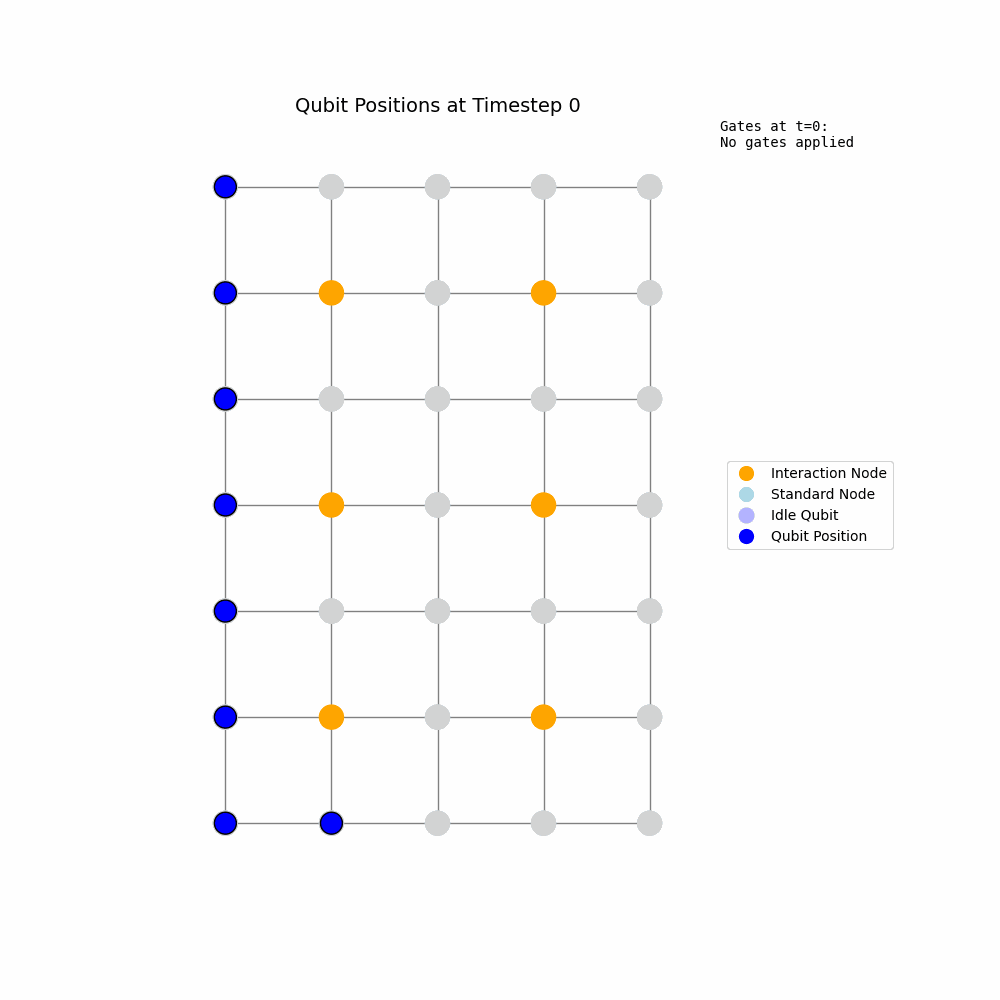

In [9]:
# %% [markdown]
## 7. Visualization (inline GIF only)

# %%
import sys, os
# make sure src/ is importable
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

import matplotlib.pyplot as plt
plt.ioff()  # turn interactive plotting off

from trap import create_trap_graph
from modules.visualization import visualize_movement_on_trap
from IPython.utils import io
from IPython.display import Image, display

# Capture/suppress any static plots or stdout/stderr from the visualize call
with io.capture_output():
    trap = create_trap_graph()
    visualize_movement_on_trap(trap, positions, gates)
    plt.close('all')  # close any figures that were created

# Now just display the saved GIF
display(Image(filename="qubit_movement.gif"))